<a href="https://colab.research.google.com/github/cerezamo/dl_ensae2020/blob/master/USPS_MNIST_GOOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning - ENSAE 2020** 

## **Cycle-GANs application** : from MNIST to USPS 

In this notebook we undertake an Image-to-Image translation using the Cycle-GANs architecture. The first section uses a simple architecture proposed in the Cycle-GAN introductory [paper](https://arxiv.org/pdf/1703.10593.pdf) and its Pytorch implementation in the following [github](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix). The task is to translate from USPS to MNIST. Section 2 proposes improvements based on [(Martin Arjovsky et al., 2017)]() and computes a Wasserstein Cycle-GAN on the same task.

This code is adapted from [yunjey](https://github.com/yunjey/) and the assignment proposed. 

#### Import packages 

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torchvision.utils as utils
import torch.nn.functional as F
import torch.utils as tutils
from torchvision import datasets
from torchvision import transforms
import numpy as np
from torchvision import datasets, models, transforms
import os 

### **Preparing the data** 

In [0]:
PATH_DATA = './data/'
RESULTS_PATH = './results/'

In [0]:
os.makedirs(PATH_DATA, exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
image_size = 32
batch_size = 64

#### Download and construct loaders for USPS and Mnist

In [0]:
def get_loader_mnist(image_size,batch_size):
    transform = transforms.Compose([
                    transforms.CenterCrop(22),
                    transforms.Resize(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,), (0.5,))
                    ])

    mnist_train = datasets.MNIST(root=PATH_DATA,
                                 download=True,
                                 transform=transform,
                                 train=True)
    
    mnist_test = datasets.MNIST(root=PATH_DATA,
                                download=True,
                                transform=transform,
                                train=False)

    train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                               batch_size=batch_size,
                                               shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                               batch_size=batch_size,
                                               shuffle=False)

    return train_loader, test_loader 

In [0]:
def get_loader_usps(image_size,batch_size):
    transform = transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,), (0.5,))
                    ])

    usps_train = datasets.USPS(root=PATH_DATA,
                               download=True,
                               transform=transform,
                               train=True)
    
    usps_test = datasets.USPS(root=PATH_DATA, 
                              download=True, 
                              transform=transform, 
                              train=False)

    train_loader = torch.utils.data.DataLoader(dataset=usps_train,
                                                batch_size=batch_size,
                                                shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset=usps_test,
                                              batch_size=batch_size,
                                              shuffle=False)

    return train_loader, test_loader 

In [0]:
M_train_loader, M_test_loader = get_loader_mnist(image_size, batch_size)

In [0]:
U_train_loader, U_test_loader = get_loader_usps(image_size, batch_size)

In [0]:
examples_mnist = enumerate(M_train_loader)
batch_idx, (example_data_mnist, example_targets_mnist) = next(examples_mnist)

examples_usps = enumerate(U_train_loader)
batch_idx, (example_data_usps, example_targets_usps) = next(examples_usps)

In [10]:
example_data_usps.shape, example_data_mnist.shape # 64 per batch, size 32x32  # 64 per batch, size 32x32 

(torch.Size([64, 1, 32, 32]), torch.Size([64, 1, 32, 32]))

#### Visualizing both collections

In [0]:
import matplotlib.pyplot as plt

In [0]:
list_label = []
list_images = []

while len(list_label)<10:
    for i in range(len(example_targets_mnist)):
        if example_targets_mnist[i].item() in list_label:
            pass
        else:
            list_label.append(example_targets_mnist[i].item())
            list_images.append(example_data_mnist[i])

list_label,list_images = zip(*sorted(zip(list_label,list_images)))

MNIST Collection :


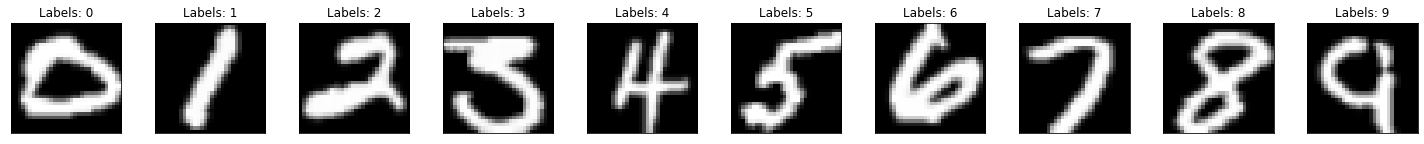

In [13]:
print("MNIST Collection :")

fig = plt.figure(figsize=(20,12))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.tight_layout()
    plt.imshow(list_images[i][0],cmap='gray', interpolation='none')
    plt.title("Labels: {}".format(list_label[i]))
    plt.xticks([])
    plt.yticks([])

In [0]:
list_label = []
list_images = []

while len(list_label)<10:
    for i in range(len(example_targets_usps)):
        if example_targets_usps[i].item() in list_label:
            pass
        else:
            list_label.append(example_targets_usps[i].item())
            list_images.append(example_data_usps[i])

list_label,list_images = zip(*sorted(zip(list_label,list_images)))

USPS Collection :


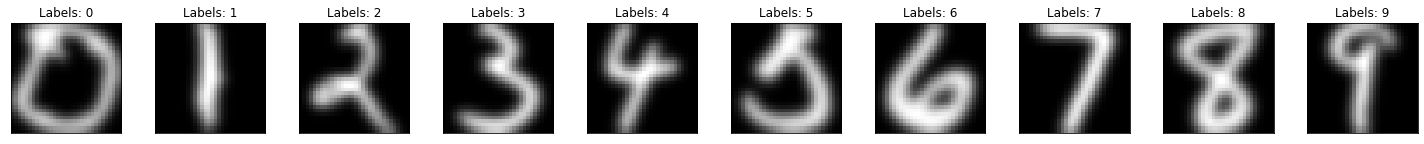

In [15]:
print("USPS Collection :")

fig = plt.figure(figsize=(20,12))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.tight_layout()
    plt.imshow(list_images[i][0],cmap='gray', interpolation='none')
    plt.title("Labels: {}".format(list_label[i]))
    plt.xticks([])
    plt.yticks([])

The USPS dataset consists of 7,291 training images and 2007 test images each of which is of the original size of 16x16. The MNIST dataset consists of 60 000 training images and 10 000 test images each of which is of the size 28x28. Both contains 10 categories (numbers from 0 to 9) and follow distinct distributions. 

### **Model Construction**

Some helper functions

In [0]:
def deconv(c_in, c_out, k_size, stride=2, pad=1, batch_norm=True):
    """Custom deconvolutional layer """
    layers = []
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=False))
    if batch_norm:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

In [0]:
def conv(c_in, c_out, k_size, stride=2, pad=1, batch_norm=True):
    """Custom convolutional layer"""
    layers = []
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=False))
    if batch_norm:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

In [0]:
def to_var(x):
    """Converts numpy to variable."""
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

In [0]:
def to_data(x):
    """Converts variable to numpy."""
    if torch.cuda.is_available():
        x = x.cpu()
    return x.data.numpy()

**Discriminator**

The discriminator takes images and tries to predict if it is real of if it is fake. In this case the discriminator is just a network that search for features in the input. 

The network consist in a serie of convolutional layer. 

In [0]:
class D_(nn.Module):
    """Discriminator for mnist."""

    def __init__(self, conv_dim=64, sigmoid_end=True):
        super(D_, self).__init__()
        self.sigmoid_end = sigmoid_end
        self.conv1 = conv(1, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        n_out = 1
        self.fc = conv(conv_dim*4, n_out, 4, 1, 0, False)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)   
        out = F.leaky_relu(self.conv2(out), 0.05) 
        out = F.leaky_relu(self.conv3(out), 0.05)  
        out = self.fc(out).squeeze()
        if self.sigmoid_end:
          out=torch.sigmoid(out)
        return out

In [21]:
D_M = D_()
D_M.cuda() # This is our discriminator architecture

D_(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Sequential(
    (0): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

An example of one batch passing through the Discriminator

In [0]:
images_M, labels_M = iter(M_train_loader).next()
images_M, labels_M = to_var(images_M), to_var(labels_M).long().squeeze()

In [23]:
print("Discriminator's output size : {}".format(D_M(images_M).size()))

Discriminator's output size : torch.Size([64])


In [24]:
print("Discriminator's output overview :")
D_M(images_M)

Discriminator's output overview :


tensor([0.5488, 0.5666, 0.5145, 0.5570, 0.6238, 0.5305, 0.5661, 0.5487, 0.5477,
        0.5739, 0.4223, 0.6414, 0.5281, 0.6120, 0.7276, 0.6988, 0.6358, 0.5028,
        0.5777, 0.5517, 0.5603, 0.4661, 0.5279, 0.6341, 0.4418, 0.4768, 0.6537,
        0.5405, 0.6105, 0.5491, 0.5969, 0.6549, 0.4788, 0.5497, 0.6680, 0.5827,
        0.7039, 0.6149, 0.5630, 0.6511, 0.5450, 0.5244, 0.4791, 0.5635, 0.5906,
        0.6643, 0.5913, 0.5856, 0.6261, 0.5455, 0.5547, 0.5773, 0.5686, 0.5819,
        0.5777, 0.5298, 0.5984, 0.5575, 0.5561, 0.6543, 0.6342, 0.6065, 0.5896,
        0.6326], device='cuda:0', grad_fn=<SigmoidBackward>)

#### Creating generators 

The Generator contains 3 relevants parts : 


1.   Encoding blocks : A convolution network that extract features from the input image 

2.   Residual blocks : 

3.   Decoding blocks : deconvolution layes work back the low-level features 






In [0]:
class G_(nn.Module):
    """Generator for transfering from mnist to usps"""
    
    def __init__(self, conv_dim=64):
        super(G_, self).__init__()
        # encoding blocks
        self.conv1 = conv(1, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)

        # residual blocks
        self.conv3 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)
        self.conv4 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)

        # decoding blocks
        self.deconv1 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv2 = deconv(conv_dim, 1, 4, batch_norm=False)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)      # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)    # (?, 128, 8, 8)

        out = F.leaky_relu(self.conv3(out), 0.05)    # ( " )
        out = F.leaky_relu(self.conv4(out), 0.05)    # ( " )

        out = F.leaky_relu(self.deconv1(out), 0.05)  # (?, 64, 16, 16)
        out = torch.tanh(self.deconv2(out))              # (?, 3, 32, 32)
        return out


In [26]:
# Check number of parameters in the generator
pytorch_total_params = sum(p.numel() for p in G_().parameters())
print("Number of parameters in the Generator's Network : {}".format(pytorch_total_params))

Number of parameters in the Generator's Network : 560128


#### Utility functions

In [0]:
def print_models(G_MtoU, G_UtoM, D_M, D_U):
    """Prints model information for the generators and discriminators.
    """
    
    print("                 G_MtoU                ")
    print("---------------------------------------")
    print(G_MtoU)
    print("---------------------------------------")

    print("                 G_UtoM                ")
    print("---------------------------------------")
    print(G_UtoM)
    print("---------------------------------------")

    print("                  D_M                  ")
    print("---------------------------------------")
    print(D_M)
    print("---------------------------------------")

    print("                  D_U                  ")
    print("---------------------------------------")
    print(D_U)
    print("---------------------------------------")

In [0]:
def weights_init(m):
    """Initialization of model weights and biases
    """

    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)

    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [0]:
def create_model():
    """Instantiate models, initialize their parameters,
    display their architecture, and send them to the GPU if available.
    """

    G_MtoU = G_().apply(weights_init)
    G_UtoM = G_().apply(weights_init)
    D_M = D_().apply(weights_init)
    D_U = D_().apply(weights_init)

    print_models(G_MtoU, G_UtoM, D_M, D_U)

    if torch.cuda.is_available():
        G_MtoU.cuda()
        G_UtoM.cuda()
        D_M.cuda()
        D_U.cuda()
        print('Models moved to GPU.')

    return G_MtoU, G_UtoM, D_M, D_U

In [0]:
def merge_images(sources, targets, k=10):
    """Creates a grid consisting of pairs of columns, where the first column in
    each pair contains images source images and the second column in each pair
    contains images generated by the CycleGAN from the corresponding images in
    the first column.
    """

    _, _, h, w = sources.shape
    row = int(np.sqrt(64))
    merged = np.zeros([3, row*h, row*w*2]) # 3

    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
        merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
        
    return merged.transpose(1, 2, 0)

In [0]:
def save_samples(iteration, fixed_U, fixed_M, G_UtoM, G_MtoU, opt_name=''):
    """Saves samples from both generators M->U and U->M.
    """

    import os
    import imageio
    fake_M = G_UtoM(fixed_U)
    fake_U = G_MtoU(fixed_M)

    M, fake_M = to_data(fixed_M), to_data(fake_M)
    U, fake_U = to_data(fixed_U), to_data(fake_U)

    merged = merge_images(M, fake_U)
    path = os.path.join(RESULTS_PATH,
                        'sample-{:06d}-M-U'.format(iteration) + opt_name + '.png')
    imageio.imwrite(path, merged)
    print('Saved {}'.format(path))

    merged = merge_images(U, fake_M)
    path = os.path.join(RESULTS_PATH,
                        'sample-{:06d}-U-M'.format(iteration) + opt_name + '.png')
    imageio.imwrite(path, merged)
    print('Saved {}'.format(path))

#### Training loop

In [32]:
G_MtoU, G_UtoM, D_M, D_U = create_model()

                 G_MtoU                
---------------------------------------
G_(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), pad

**Partie à retirer?**

In [0]:
iter_M = iter(M_train_loader)
iter_U = iter(U_train_loader)

In [0]:
images_M, labels_M = iter_M.next()
images_M, labels_M = to_var(images_M), to_var(labels_M).long().squeeze()

In [0]:
# Compute the discriminator losses on real images
out_M = D_M(images_M) # discriminator mnist true
#D_M_loss = torch.mean((out_M-1)**2) 

In [36]:
out_M

tensor([0.2238, 0.3255, 0.2721, 0.2399, 0.3723, 0.4839, 0.3233, 0.1079, 0.1530,
        0.4444, 0.3731, 0.2430, 0.1379, 0.1059, 0.3545, 0.5004, 0.2083, 0.3618,
        0.2512, 0.2755, 0.2568, 0.3200, 0.2189, 0.3595, 0.1951, 0.1530, 0.1911,
        0.5483, 0.1409, 0.2495, 0.1920, 0.3544, 0.1081, 0.1792, 0.2707, 0.1926,
        0.4495, 0.4649, 0.2793, 0.2592, 0.5814, 0.2050, 0.1210, 0.2632, 0.2588,
        0.2437, 0.5144, 0.5114, 0.2868, 0.3944, 0.1690, 0.1957, 0.4257, 0.1920,
        0.4271, 0.2529, 0.1977, 0.2141, 0.0643, 0.0575, 0.2953, 0.3731, 0.1458,
        0.2680], device='cuda:0', grad_fn=<SigmoidBackward>)

In [37]:
torch.mean((out_M-1)**2).item(), torch.mean(out_M-1).item()

(0.5362670421600342, -0.7218909859657288)

Within the training loop, we train the GAN loss $\mathcal{L}_{\mathrm{GAN}}(G, D, X, Y)$ in the following way: 
   
1 - the **Discriminator** $D$ to minimize $\mathbb{E}_{x \sim p_{\text {data }}(x)}\left[(D(G(x))-1)^{2}\right]$  
  
2 - the **Generator** $G$ to minimize $\mathbb{E}_{y \sim p_{\text {data }}(y)}\left[(D(y)-1)^{2}\right] + \mathbb{E}_{x \sim p_{\text {data }}(x)}\left[D(G(x))^{2}\right]$

In [0]:
def training_loop(M_train_loader, U_train_loader, M_test_loader, U_test_loader,
                  sample_every=1000,  lr=0.0002, train_iters=20000, log_step=10,
                  batch_size=64, use_cycle_consistency_loss=True, cyc_lambda=1,
                  opt_name=''):
    

    # Create Generators and Discriminators
    G_MtoU, G_UtoM, D_M, D_U = create_model()

    # Get Generator parameters
    g_params = list(G_MtoU.parameters()) + list(G_UtoM.parameters())
    # Get Discriminator parameters
    d_params = list(D_M.parameters()) + list(D_U.parameters())  

    # Create optimizers for the generators and discriminators
    g_optimizer = optim.Adam(g_params, lr)
    d_optimizer = optim.Adam(d_params, lr)

    iter_M = iter(M_train_loader)
    iter_U = iter(U_train_loader)

    test_iter_M = iter(M_test_loader)
    test_iter_U = iter(U_test_loader)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_M = to_var(test_iter_M.next()[0])
    fixed_U = to_var(test_iter_U.next()[0])

    # Datasets don's have the same length, we choose the smaller one to drive the
    # number of iterations per epoch
    iter_per_epoch = min(len(iter_M), len(iter_U))



    for iteration in range(1, train_iters+1):

        # Reset data_iter for each epoch
        if iteration % iter_per_epoch == 0:
            iter_M = iter(M_train_loader)
            iter_U = iter(U_train_loader)

        images_M, labels_M = iter_M.next()
        images_M, labels_M = to_var(images_M), to_var(labels_M).long().squeeze()

        images_U, labels_U = iter_U.next()
        images_U, labels_U = to_var(images_U), to_var(labels_U).long().squeeze()


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ### Train with real images
        d_optimizer.zero_grad()

        # Compute the Discriminator's losses on real images
        out_M = D_M(images_M) # Discriminator MNIST true
        D_M_loss = torch.mean((out_M-1)**2) 

        out_U = D_U(images_U) # Discriminator USPS true
        D_U_loss = torch.mean((out_U-1)**2)

        d_real_loss = D_M_loss + D_U_loss
        d_real_loss.backward()
        d_optimizer.step()


        ### Train with fake images
        d_optimizer.zero_grad()

        # Generate fake images that look like domain MNIST based on real images in domain USPS
        fake_M = G_UtoM(images_U)

        # Compute the loss for D_M
        out_M = D_M(fake_M)
        D_M_loss = torch.mean(out_M**2) 

        # Generate fake images that look like domain U based on real images in domain M
        fake_U = G_MtoU(images_M)

        # Compute the loss for D_U
        out_U = D_U(fake_U)
        D_U_loss = torch.mean((out_U)**2) 

        d_fake_loss = D_M_loss + D_U_loss
        d_fake_loss.backward()
        d_optimizer.step()

        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ## USPS--MNIST-->USPS 

        g_optimizer.zero_grad()

        # Generate fake images that look like domain MNIST based on real images
        # in domain USPS
        fake_M = G_UtoM(images_U)
        out = D_M(fake_M)

        # Compute the generator loss based on domain MNIST
        g_loss = torch.mean((out-1)**2)

        if use_cycle_consistency_loss:
            reconstructed_U = G_MtoU(fake_M)
            # Compute the cycle consistency loss (the reconstruction loss)
            cycle_consistency_loss = torch.mean((images_U - reconstructed_U)**2)
            g_loss += cyc_lambda * cycle_consistency_loss

        g_loss.backward()
        g_optimizer.step()


        ## MNIST--USPS-->MNIST 

        g_optimizer.zero_grad()

        # Generate fake images that look like domain USPS based on real images 
        # in domain MNIST
        fake_U = G_MtoU(images_M)
        out = D_U(fake_U)

        # Compute the generator loss based on domain USPS
        g_loss = torch.mean((out-1)**2)

        if use_cycle_consistency_loss:
            reconstructed_M = G_UtoM(fake_U)
            # Compute the cycle consistency loss (the reconstruction loss)
            cycle_consistency_loss = torch.mean((images_M - reconstructed_M)**2)
            g_loss += cyc_lambda * cycle_consistency_loss

        g_loss.backward()
        g_optimizer.step()


        # Print the log info
        if iteration % log_step == 0:
            print('Iteration [{:5d}/{:5d}] | d_real_loss: {:6.4f} | d_U_loss: {:6.4f} | d_M_loss: {:6.4f} | '
                'd_fake_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    iteration, train_iters, d_real_loss.item(), D_U_loss.item(),
                    D_M_loss.item(), d_fake_loss.item(), g_loss.item()))


        # Save the generated samples
        if iteration % sample_every == 0:
            save_samples(iteration, fixed_U, fixed_M, G_UtoM, G_MtoU, opt_name=opt_name)

Traning with `use_cycle_consistency_loss = True`.

In [39]:
training_loop(M_train_loader, U_train_loader, M_test_loader, U_test_loader,
              sample_every=1000,  lr=0.0002, train_iters=2000, log_step = 100,
              use_cycle_consistency_loss=True, cyc_lambda=1)

                 G_MtoU                
---------------------------------------
G_(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), pad

Iteration [ 1000/ 2000] | d_real_loss: 0.2787 | d_U_loss: 0.1481 | d_M_loss: 0.1002 | d_fake_loss: 0.2484 | g_loss: 0.7389
Saved ./results/sample-001000-M-U.png
Saved ./results/sample-001000-U-M.png
Iteration [ 1100/ 2000] | d_real_loss: 0.4121 | d_U_loss: 0.0558 | d_M_loss: 0.1053 | d_fake_loss: 0.1612 | g_loss: 0.7605
Iteration [ 1200/ 2000] | d_real_loss: 0.1287 | d_U_loss: 0.0902 | d_M_loss: 0.1302 | d_fake_loss: 0.2203 | g_loss: 0.8278
Iteration [ 1300/ 2000] | d_real_loss: 0.1423 | d_U_loss: 0.0475 | d_M_loss: 0.0615 | d_fake_loss: 0.1090 | g_loss: 0.8750
Iteration [ 1400/ 2000] | d_real_loss: 0.0791 | d_U_loss: 0.0976 | d_M_loss: 0.0566 | d_fake_loss: 0.1542 | g_loss: 0.8699
Iteration [ 1500/ 2000] | d_real_loss: 0.2049 | d_U_loss: 0.1404 | d_M_loss: 0.0286 | d_fake_loss: 0.1690 | g_loss: 0.6407
Iteration [ 1600/ 2000] | d_real_loss: 0.1819 | d_U_loss: 0.1187 | d_M_loss: 0.0395 | d_fake_loss: 0.1581 | g_loss: 0.7752
Iteration [ 1700/ 2000] | d_real_loss: 0.1544 | d_U_loss: 0.096

Iteration [ 2000/ 2000] | d_real_loss: 0.2104 | d_U_loss: 0.0683 | d_M_loss: 0.0596 | d_fake_loss: 0.1279 | g_loss: 0.7521
Saved ./results/sample-002000-M-U.png
Saved ./results/sample-002000-U-M.png


Results :

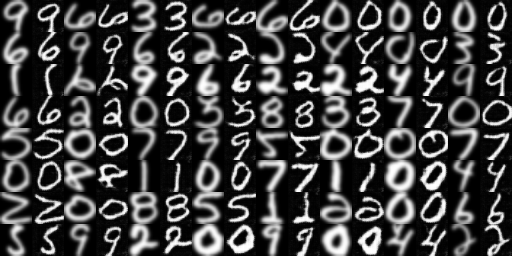

In [41]:
from PIL import Image
image = Image.open(os.path.join(RESULTS_PATH, 'sample-002000-U-M.png'))
image

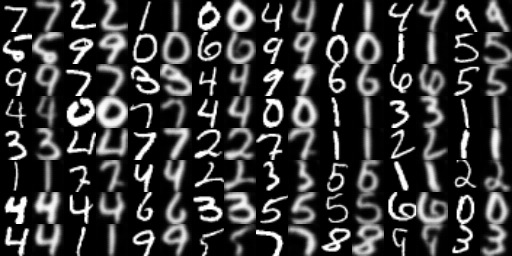

In [42]:
from PIL import Image
image = Image.open(os.path.join(RESULTS_PATH, 'sample-002000-M-U.png'))
image

Traning with `use_cycle_consistency_loss = False`.

In [48]:
training_loop(M_train_loader, U_train_loader, M_test_loader, U_test_loader,
              sample_every=1000,  lr=0.0002, train_iters=2000, log_step = 100,
              use_cycle_consistency_loss=False, opt_name='_no_cycle')

                 G_MtoU                
---------------------------------------
G_(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), pad

NameError: ignored

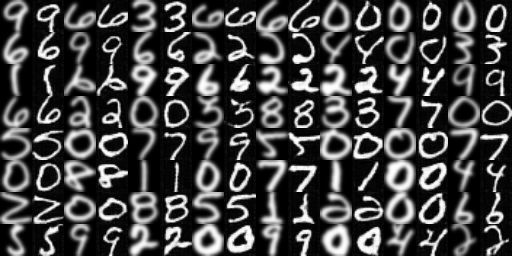

In [63]:
from PIL import Image
image = Image.open(os.path.join(RESULTS_PATH, 'sample-005000-U-M_no_cycle.png'))
image

In [0]:
from PIL import Image
image = Image.open(os.path.join(RESULTS_PATH, 'sample-005000-M-U_no_cycle.png'))
image

# Testing Wassesrstein Cycle GAN 

What we need to modify : 
1. Turning the Adam optimizer into the RMS Prop optimizer 
2. The discriminator should not end with a sigmoid on the last layer (this is ok) 
3. D_loss =  -torch.mean(discriminator(real_imgs)) + torch.mean(discriminator(fake_imgs))


G_loss = -torch.mean(D_fake)

4. Clip parameters 

In [0]:
def training_loop(def training_loop(M_train_loader, U_train_loader, M_test_loader, U_test_loader,
                  sample_every=1000,  lr=0.0002, train_iters=20000, log_step=10,
                  batch_size=64, use_cycle_consistency_loss=True, cyc_lambda=1,
                  opt_name=''):
    
    # Create generators and discriminators
    G_MtoU, G_UtoM, D_M, D_U = create_model()

    g_params = list(G_MtoU.parameters()) + list(G_UtoM.parameters())  # Get generator parameters
    d_m_params = list(D_M.parameters())  # Get discriminator parameters
    d_u_params = list(D_U.parameters())  # Get discriminator parameters

    # Create optimizers for the generators and discriminators
    g_optimizer = optim.RMSprop(g_params, lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
    d_m_optimizer = optim.RMSprop(d_m_params, lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
    d_u_optimizer = optim.RMSprop(d_u_params, lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

    iter_M = iter(M_train_loader)
    iter_U = iter(U_train_loader)

    test_iter_M = iter(M_test_loader)
    test_iter_U = iter(U_test_loader)

    fixed_M = to_var(test_iter_M.next()[0])
    fixed_U = to_var(test_iter_U.next()[0])

    iter_per_epoch = min(len(iter_M), len(iter_U))

    for iteration in range(1, train_iters+1):

        # Reset data_iter for each epoch
        if iteration % iter_per_epoch == 0:
            iter_M = iter(M_train_loader)
            iter_U = iter(U_train_loader)

        images_M, labels_M = iter_M.next()
        images_M, labels_M = to_var(images_M), to_var(labels_M).long().squeeze()

        images_U, labels_U = iter_U.next()
        images_U, labels_U = to_var(images_U), to_var(labels_U).long().squeeze()

        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        for _ in range(5):
            # Train with real images
            d_m_optimizer.zero_grad()
            d_u_optimizer.zero_grad()

            # Compute the discriminator losses on real images
            out_M = D_M(images_M) # discriminator mnist true
            D_M_loss = - torch.mean(out_M) 

            out_U = D_U(images_U)
            D_U_loss = - torch.mean(out_U)

            d_real_loss = D_M_loss + D_U_loss
            d_real_loss_m = D_M_loss
            d_real_loss_u = D_U_loss
            #d_real_loss.backward()
            #d_optimizer.step()

            # Train with fake images
            #d_optimizer.zero_grad()

            # Generate fake images that look like domain MNIST based on real images in domain USPS
            fake_M = G_UtoM(images_U)

            # Compute the loss for D_M
            out_M = D_M(fake_M)
            D_M_loss =  torch.mean(out_M) 

            # 4. Generate fake images that look like domain U based on real images in domain M
            fake_U = G_MtoU(images_M)

            # 5. Compute the loss for D_U
            out_U = D_U(fake_U)
            D_U_loss = torch.mean(out_U) 

            d_fake_loss = D_M_loss + D_U_loss

            d_loss = d_real_loss + d_fake_loss

            d_fake_loss_m = D_M_loss
            d_fake_loss_u = D_U_loss

            d_loss_m = d_real_loss_m + d_fake_loss_m
            d_loss_u = d_real_loss_u + d_fake_loss_u

            d_loss_u.backward()
            d_loss_m.backward()

            d_m_optimizer.step()
            d_u_optimizer.step()

            #d_loss.backward()
            #d_optimizer.step()

            # Clipping discriminator parameters 
            for p in D_M.parameters():
                p.data.clamp_(-0.01, 0.01)
            
            # Clipping discriminator parameters 
            for p in D_U.parameters():
                p.data.clamp_(-0.01, 0.01)

      # =========================================
      #            TRAIN THE GENERATORS
      # =========================================

      ## U--M-->U 

        g_optimizer.zero_grad()

        # 1. Generate fake images that look like domain M based on real images in domain U
        fake_M = G_UtoM(images_U)
        out = D_M(fake_M)

        # 2. Compute the generator loss based on domain M

        g_loss = - torch.mean(out)

        if use_cycle_consistency_loss:
            reconstructed_U = G_MtoU(fake_M)
            # 3. Compute the cycle consistency loss (the reconstruction loss)
            cycle_consistency_loss = torch.mean((images_U - reconstructed_U)**2)
            g_loss += cycle_consistency_loss

        # 1. Generate fake images that look like domain U based on real images in domain M
        fake_U = G_MtoU(images_M)
        out = D_U(fake_U)

        # 2. Compute the generator loss based on domain U
        #g_loss = - torch.mean(out)
        g_loss += - torch.mean(out)

        if use_cycle_consistency_loss:
            reconstructed_M = G_UtoM(fake_U)
            # 3. Compute the cycle consistency loss (the reconstruction loss)
            cycle_consistency_loss = torch.mean((images_M - reconstructed_M)**2)
            g_loss += cycle_consistency_loss

        g_loss.backward()
        g_optimizer.step()


      # Print the log info
        if iteration % log_step == 0:
            print('Iteration [{:5d}/{:5d}] | d_real_loss: {:6.4f} | d_U_loss: {:6.4f} | d_M_loss: {:6.4f} | '
                'd_fake_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    iteration, train_iters, d_real_loss.item(), D_U_loss.item(),
                    D_M_loss.item(), d_fake_loss.item(), g_loss.item()))


        # Save the generated samples
        if iteration % sample_every == 0:
            save_samples(iteration, fixed_U, fixed_M, G_UtoM, G_MtoU, opt_name=opt_name)

In [0]:
training_loop(M_train_loader, U_train_loader, M_test_loader, U_test_loader,
              sample_every=1000,  lr=0.0002, train_iters=5000, log_step = 100,
              use_cycle_consistency_loss=False, opt_name='_wass')

                 G_MtoU                
---------------------------------------
G_MNIST_USPS(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(

Iteration [ 1000/ 5000] | d_real_loss: -0.4124 | d_U_loss: 0.0946 | d_M_loss: 0.0057 | d_fake_loss: 0.1003 | g_loss: 0.4309
Saved /content/sample-001000-M-U.png
Saved /content/sample-001000-U-M.png
Iteration [ 1100/ 5000] | d_real_loss: -0.2091 | d_U_loss: -0.0367 | d_M_loss: -0.1201 | d_fake_loss: -0.1568 | g_loss: 0.2553
Iteration [ 1200/ 5000] | d_real_loss: -0.2281 | d_U_loss: 0.0239 | d_M_loss: -0.1717 | d_fake_loss: -0.1478 | g_loss: 0.2339
Iteration [ 1300/ 5000] | d_real_loss: -0.1451 | d_U_loss: -0.1951 | d_M_loss: -0.0334 | d_fake_loss: -0.2285 | g_loss: 0.2073
Iteration [ 1400/ 5000] | d_real_loss: -0.2063 | d_U_loss: 0.0349 | d_M_loss: -0.1641 | d_fake_loss: -0.1292 | g_loss: 0.2399
Iteration [ 1500/ 5000] | d_real_loss: -0.3129 | d_U_loss: 0.0821 | d_M_loss: -0.1149 | d_fake_loss: -0.0328 | g_loss: 0.2907
Iteration [ 1600/ 5000] | d_real_loss: 0.0523 | d_U_loss: -0.1791 | d_M_loss: -0.1544 | d_fake_loss: -0.3336 | g_loss: 0.1110
Iteration [ 1700/ 5000] | d_real_loss: -0.12

Iteration [ 2000/ 5000] | d_real_loss: -0.1396 | d_U_loss: 0.0277 | d_M_loss: -0.1790 | d_fake_loss: -0.1512 | g_loss: 0.1112
Saved /content/sample-002000-M-U.png
Saved /content/sample-002000-U-M.png
Iteration [ 2100/ 5000] | d_real_loss: -0.1380 | d_U_loss: -0.1176 | d_M_loss: -0.0548 | d_fake_loss: -0.1725 | g_loss: 0.1081
Iteration [ 2200/ 5000] | d_real_loss: -0.2318 | d_U_loss: -0.0026 | d_M_loss: -0.0972 | d_fake_loss: -0.0997 | g_loss: 0.3379
Iteration [ 2300/ 5000] | d_real_loss: -0.1340 | d_U_loss: 0.0013 | d_M_loss: -0.1525 | d_fake_loss: -0.1512 | g_loss: 0.1743
Iteration [ 2400/ 5000] | d_real_loss: -0.1555 | d_U_loss: -0.0638 | d_M_loss: -0.0999 | d_fake_loss: -0.1637 | g_loss: 0.2592
Iteration [ 2500/ 5000] | d_real_loss: -0.1445 | d_U_loss: -0.0671 | d_M_loss: -0.0568 | d_fake_loss: -0.1239 | g_loss: 0.1956
Iteration [ 2600/ 5000] | d_real_loss: 0.0378 | d_U_loss: -0.0925 | d_M_loss: -0.1825 | d_fake_loss: -0.2750 | g_loss: -0.0226
Iteration [ 2700/ 5000] | d_real_loss: 

Iteration [ 3000/ 5000] | d_real_loss: -0.2600 | d_U_loss: -0.0396 | d_M_loss: -0.0292 | d_fake_loss: -0.0689 | g_loss: 0.3601
Saved /content/sample-003000-M-U.png
Saved /content/sample-003000-U-M.png
Iteration [ 3100/ 5000] | d_real_loss: -0.0426 | d_U_loss: -0.0641 | d_M_loss: -0.1778 | d_fake_loss: -0.2419 | g_loss: 0.0277
Iteration [ 3200/ 5000] | d_real_loss: -0.1807 | d_U_loss: -0.0201 | d_M_loss: -0.1142 | d_fake_loss: -0.1343 | g_loss: 0.1791
Iteration [ 3300/ 5000] | d_real_loss: -0.1422 | d_U_loss: -0.0316 | d_M_loss: -0.1097 | d_fake_loss: -0.1413 | g_loss: 0.1719
Iteration [ 3400/ 5000] | d_real_loss: -0.0369 | d_U_loss: -0.0707 | d_M_loss: -0.1775 | d_fake_loss: -0.2481 | g_loss: 0.1117
Iteration [ 3500/ 5000] | d_real_loss: -0.1060 | d_U_loss: -0.0670 | d_M_loss: -0.1047 | d_fake_loss: -0.1717 | g_loss: 0.1026
Iteration [ 3600/ 5000] | d_real_loss: -0.1886 | d_U_loss: -0.0098 | d_M_loss: -0.0858 | d_fake_loss: -0.0956 | g_loss: 0.3044
Iteration [ 3700/ 5000] | d_real_loss

Iteration [ 4000/ 5000] | d_real_loss: -0.0839 | d_U_loss: -0.0807 | d_M_loss: -0.0916 | d_fake_loss: -0.1724 | g_loss: 0.1768
Saved /content/sample-004000-M-U.png
Saved /content/sample-004000-U-M.png
Iteration [ 4100/ 5000] | d_real_loss: -0.0674 | d_U_loss: -0.0949 | d_M_loss: -0.1036 | d_fake_loss: -0.1984 | g_loss: 0.1196
Iteration [ 4200/ 5000] | d_real_loss: -0.1708 | d_U_loss: -0.0734 | d_M_loss: -0.0720 | d_fake_loss: -0.1454 | g_loss: 0.2532
Iteration [ 4300/ 5000] | d_real_loss: -0.1243 | d_U_loss: -0.0564 | d_M_loss: -0.0980 | d_fake_loss: -0.1544 | g_loss: 0.1408
Iteration [ 4400/ 5000] | d_real_loss: -0.0253 | d_U_loss: -0.0537 | d_M_loss: -0.1777 | d_fake_loss: -0.2314 | g_loss: 0.0139
Iteration [ 4500/ 5000] | d_real_loss: -0.0564 | d_U_loss: -0.0747 | d_M_loss: -0.1809 | d_fake_loss: -0.2556 | g_loss: 0.1583
Iteration [ 4600/ 5000] | d_real_loss: -0.1041 | d_U_loss: 0.0367 | d_M_loss: -0.1837 | d_fake_loss: -0.1471 | g_loss: 0.0160
Iteration [ 4700/ 5000] | d_real_loss:

Iteration [ 5000/ 5000] | d_real_loss: -0.0702 | d_U_loss: -0.0936 | d_M_loss: -0.1226 | d_fake_loss: -0.2162 | g_loss: 0.1375
Saved /content/sample-005000-M-U.png
Saved /content/sample-005000-U-M.png
